<a href="https://colab.research.google.com/github/Jorgecardetegit/NLP/blob/main/Neural_Machine_Translator_(French_to_English)_with_HuggingFace_%F0%9F%A4%97.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Neural Machine Translation with T5**

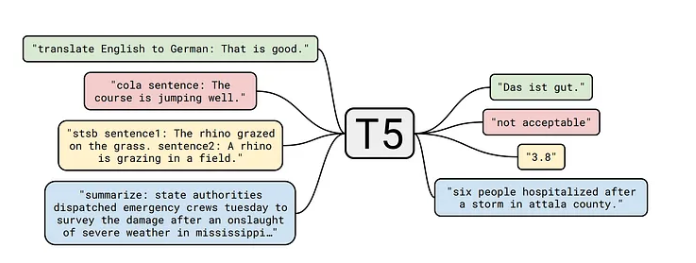

## **T5 overview**

T5, or Text-To-Text Transfer Transformer, is a model developed by Google Research, which treats every NLP problem as a text-to-text problem. Instead of having different models or architectures for various NLP tasks, T5 aims to use a unified approach to handle any task that can be framed as converting input text into output text.

T5 (Text-To-Text Transfer Transformer) is based on an **encoder-decoder architecture**. The **encoder** processes the input text and creates a representation of it, which is then used by the **decoder** to generate the output text.

To know more about T5 see HuggingFace docuemntaion and its original paper:

https://huggingface.co/docs/transformers/model_doc/t5

https://arxiv.org/pdf/1910.10683.pdf


## **About the dataset**

The dataset used in this analysis will be the kaggle **English-French Translation Dataset**.

French/English parallel texts for training translation models. Over 22.5 million sentences in French and English. Dataset created by Chris Callison-Burch, who crawled millions of web pages and then used a set of simple heuristics to transform French URLs onto English URLs, and assumed that these documents are translations of each other. This is the main dataset of Workshop on Statistical Machine Translation (WML) 2015 Dataset that can be used for Machine Translation and Language Models.

Check the paper of the dataset for a more in depth description:

https://www.statmt.org/wmt15/pdf/WMT01.pdf



# 1. Import libraries and install dependecies

In [ ]:
import importlib.util

# Function to check if a library is installed
def is_library_installed(name):
    spec = importlib.util.find_spec(name)
    return spec is not None

# Check if both 'transformers' and 'datasets' are installed
if not is_library_installed('transformers') or not is_library_installed('datasets') or not is_library_installed('sacrebleu'): #or not is_library_installed('evaluate'):
    !pip install transformers datasets evaluate

    # !pip install sacreblue

## Libraries

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
from PIL import Image

from numpy import random

In [ ]:
from transformers import T5TokenizerFast, T5ForConditionalGeneration
from transformers import DataCollatorWithPadding, create_optimizer, AutoTokenizer, DataCollatorForSeq2Seq, TFAutoModelForSeq2SeqLM

from datasets import load_dataset

import evaluate


In [ ]:
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Dense,Flatten,InputLayer,BatchNormalization,Dropout,Input,LayerNormalization
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam

In [ ]:
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve

In [ ]:
import datetime
import pathlib
import io
import os
import re
import string
import time
import gensim.downloader as api

In [ ]:
from google.colab import drive
from google.colab import files

drive.mount('/content/drive')

Mounted at /content/drive


# 2. Load dataset

In [ ]:
def upload_file(file_name):
    # Check if the file already exists
    if os.path.exists(file_name):
        print(f'{file_name} already exists.')
    else:
        # If not, upload the file
        uploaded = files.upload()

        # Rename the uploaded file (if necessary)
        uploaded_file_name = list(uploaded.keys())[0]
        if uploaded_file_name != file_name:
            os.rename(uploaded_file_name, file_name)
            print(f'File uploaded and renamed to {file_name}.')
        else:
            print(f'File uploaded as {file_name}.')

# Replace 'your_file.txt' with the name of the file you want to upload
upload_file(r"kaggle.json")

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d dhruvildave/en-fr-translation-dataset

100% 2.54G/2.54G [00:35<00:00, 86.6MB/s]
100% 2.54G/2.54G [00:35<00:00, 77.3MB/s]


In [ ]:
!unzip "/content/en-fr-translation-dataset.zip" -d "/content/dataset/"

Archive:  /content/en-fr-translation-dataset.zip
  inflating: /content/dataset/en-fr.csv  


In [ ]:
dataset = load_dataset("text", data_files = "/content/dataset/en-fr.csv")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

# 3. Basic EDA

In [ ]:
print(dataset)

print(f"\nStructure of the dataset: {type(dataset['train'])}")

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 22520377
    })
})

Structure of the dataset: <class 'datasets.arrow_dataset.Dataset'>


In [ ]:
dataset['train'].column_names

['text']

In [ ]:
for line in dataset['train'].select(list(range(10))):
  print(line)

{'text': 'en,fr'}
{'text': 'Changing Lives | Changing Society | How It Works | Technology Drives Change Home | Concepts | Teachers | Search | Overview | Credits | HHCC Web | Reference | Feedback Virtual Museum of Canada Home Page,"Il a transformé notre vie | Il a transformé la société | Son fonctionnement | La technologie, moteur du changement Accueil | Concepts | Enseignants | Recherche | Aperçu | Collaborateurs | Web HHCC | Ressources | Commentaires Musée virtuel du Canada"'}
{'text': 'Site map,Plan du site'}
{'text': 'Feedback,Rétroaction'}
{'text': 'Credits,Crédits'}
{'text': 'Français,English'}
{'text': 'What is light ?,Qu’est-ce que la lumière?'}
{'text': 'The white light spectrum Codes in the light The electromagnetic spectrum Emission spectra Absorption spectra Light-years Light pollution,La découverte du spectre de la lumière blanche Des codes dans la lumière Le spectre électromagnétique Les spectres d’émission Les spectres d’absorption Les années-lumière La pollution lumineus

# 4. Preprocessing

In [ ]:
model_id="t5-small"
tokenizer=T5TokenizerFast.from_pretrained(model_id)

In [ ]:
prefix = "translate English to French: "

def preprocess_function(examples):

  inputs = [prefix + example[0] for example in examples['text']]
  targets = [example[1] for example in examples['text']]

  model_inputs = tokenizer(inputs, text_target=targets,max_length=128, truncation=True)
  return model_inputs

In [ ]:
tokenized_dataset=dataset.map(preprocess_function,batched=True)

Map:   0%|          | 0/22520377 [00:00<?, ? examples/s]

In [43]:
cleaned_dataset = tokenized_dataset.remove_columns("text")

# 5. Preparing data for modelling

In [45]:
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_id)
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer,model=model, return_tensors="tf")

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [46]:
BATCH_SIZE = 8
tf_train_set = cleaned_dataset["train"].to_tf_dataset(
    shuffle=True,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
)

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [47]:
train_data=tf_train_set.take(int(0.9*len(tf_train_set)))
val_data=tf_train_set.skip(int(0.9*len(tf_train_set)))

# 6. Model architecture

In [48]:
model.summary()

Model: "tft5_for_conditional_generation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 shared (Embedding)          multiple                  16449536  
                                                                 
 encoder (TFT5MainLayer)     multiple                  35330816  
                                                                 
 decoder (TFT5MainLayer)     multiple                  41625344  
                                                                 
Total params: 60506624 (230.81 MB)
Trainable params: 60506624 (230.81 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#7. Training

In [49]:
num_epochs = 3
num_train_steps = len(train_data) * num_epochs

optimizer, schedule = create_optimizer(
    init_lr=2e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
)
model.compile(optimizer=optimizer)

In [50]:
model.fit(
  train_data,
  validation_data=val_data,
  epochs=3
)

Epoch 1/3
     13/2533543 [..............................] - ETA: 2188:59:22 - loss: 3.9677

InvalidArgumentError: ignored

#8. Evaluation

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
all_preds = []
all_labels = []

for batch in val_data:
  predictions = model.generate(
      input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
  )
  decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
  labels = batch["labels"].numpy()
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
  all_preds.extend(decoded_preds)
  all_labels.extend(decoded_labels)

result = metric.compute(predictions=all_preds, references=all_labels)
print(result)metric = evaluate.load("sacrebleu")

# 9. Testing

In [ ]:
original_model = TFAutoModelForSeq2SeqLM.from_pretrained(model_id)

In [ ]:
input_text="Have you ever played soccer under the rain, with your friends? "
#input_text="Google Translate is a multilingual neural machine translation service developed by Google to translate text, documents and websites from one language into another."
input_text=prefix + input_text
tokenized=tokenizer([input_text], return_tensors='tf')
out = original_model.generate(**tokenized, max_length=128)
print(out)